# **<p style="text-align:center;">Initial setup</p>**


In [1]:
%run setup.py

In [2]:
train = load_data(data_train_path)
test = load_data(data_test_path)
id = test["id"]

In [3]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


# **<p style="text-align:center;">Preliminary analysis</p>**

In [5]:
# check NaN and remove if necessary
train.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [6]:
test.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [7]:
test["winddirection"].fillna(test["winddirection"].mean(), inplace=True)

C:\Users\Nevada\AppData\Local\Temp\ipykernel_5112\89629749.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["winddirection"].fillna(test["winddirection"].mean(), inplace=True)


In [8]:
# correct label mistake
train['temperature'] = train['temparature']
train.drop(columns='temparature', inplace=True)
test['temperature'] = test['temparature']
test.drop(columns='temparature', inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
 12  temperature    2190 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


We have 6 years of data, so we can add a year and a month features to check for seasonality or trend in the rainfalls later.

In [10]:
# create year column
train["year"] = (train["id"]) // 365
train["year"] +=1
test["year"] = (test["id"]) // 365
test["year"] +=1

In [11]:
# create month column using datetime

# Create a "fake" real date by treating all "years" as the same (e.g., 2001)
train['date'] = pd.to_datetime('2001-01-01') + pd.to_timedelta(train['day'] - 1, unit='D')
test['date'] = pd.to_datetime('2001-01-01') + pd.to_timedelta(test['day'] - 1, unit='D')
# Extract the month from the date
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

# drop the date
train.drop(columns='date', inplace=True)
test.drop(columns='date', inplace=True)
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
train.drop(columns='day', inplace=True)
test.drop(columns='day', inplace=True)

In [12]:
# target
y = train["rainfall"]
# features
X = train.drop(columns="rainfall")
X_test = test

# **<p style="text-align:center;">Target Analysis</p>**

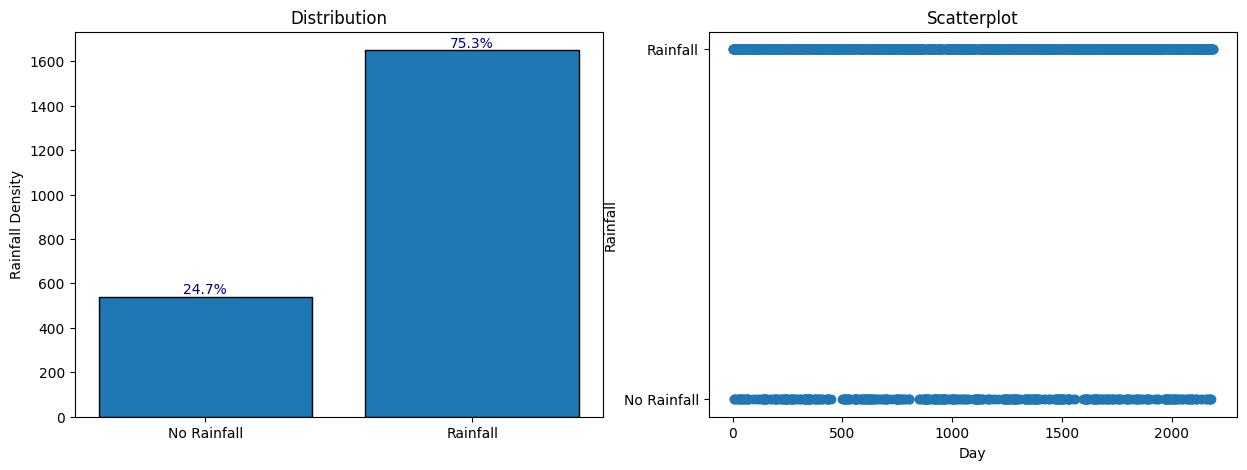

In [13]:
#Call basic visualization function
plot_binary_target(y, "Day", "Rainfall")

Rain is more common, but not much info otherwise. 

So we can look at the yearly and monthly info.

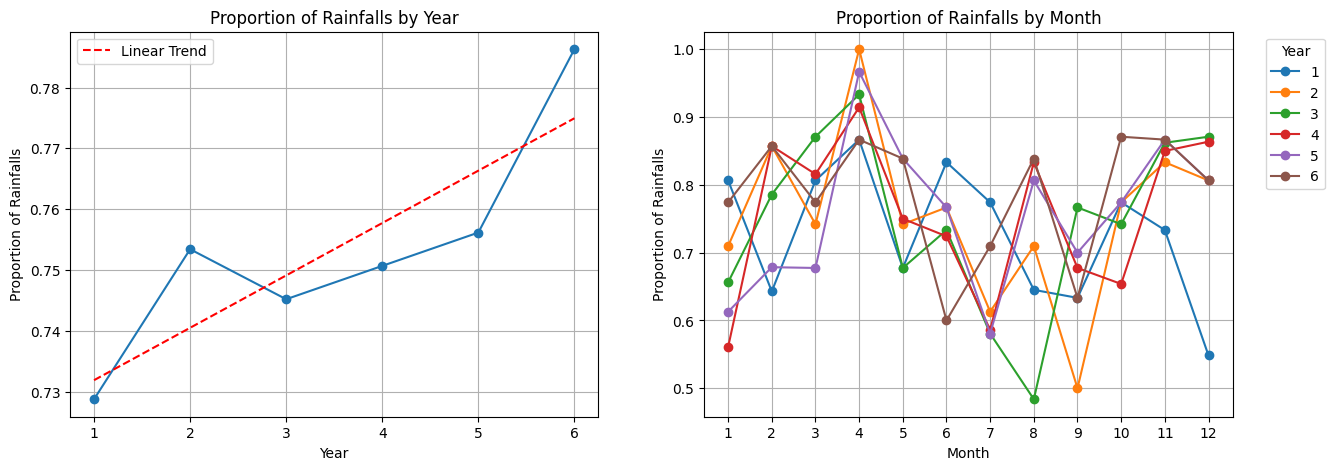

In [14]:
# Look for a trend & seasonality using yearly and monthly Rainfalls
plot_yearly_monthly(train, y,'Rainfalls')

There seem to be a trend with rainfalls, so taking into account the time aspect of the dataset is necessary. Only a few years though.

Clear outlier is April, and there seems to be seasonality with max around April and min around August, September. Monthly categories could bring good info.

# **<p style="text-align:center;">Features Analysis</p>**

First thing to do is take care of the temporal features. 

For year it is ok since it is monotonous in nature and already an ordinal categorical feature.

However, months are cyclical categories, so we need a specific cyclical encoding.

In [15]:
# encode monthly data
X['month_cos'] = cos_transformer(12).fit_transform(X)['month']
X['month_sin'] = sin_transformer(12).fit_transform(X)['month']
X.drop(columns=["month"],inplace=True)
X_test['month_cos'] = cos_transformer(12).fit_transform(X_test)['month']
X_test['month_sin'] = sin_transformer(12).fit_transform(X_test)['month']
X_test.drop(columns=["month"],inplace=True)

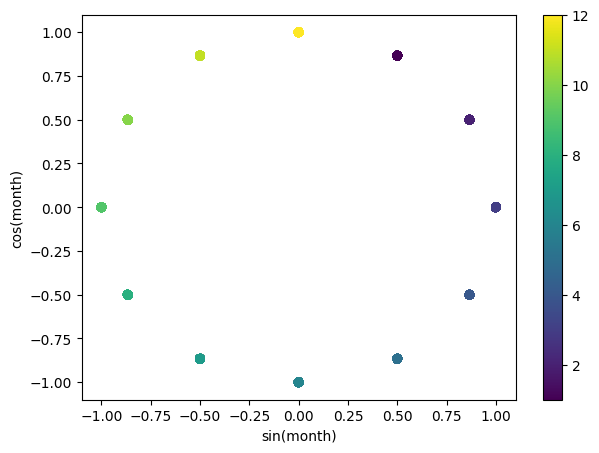

In [16]:
# verify encoding
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(X["month_sin"], X["month_cos"], c=train["month"])
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)

Next we look at the distribution and basic statistics of all features.

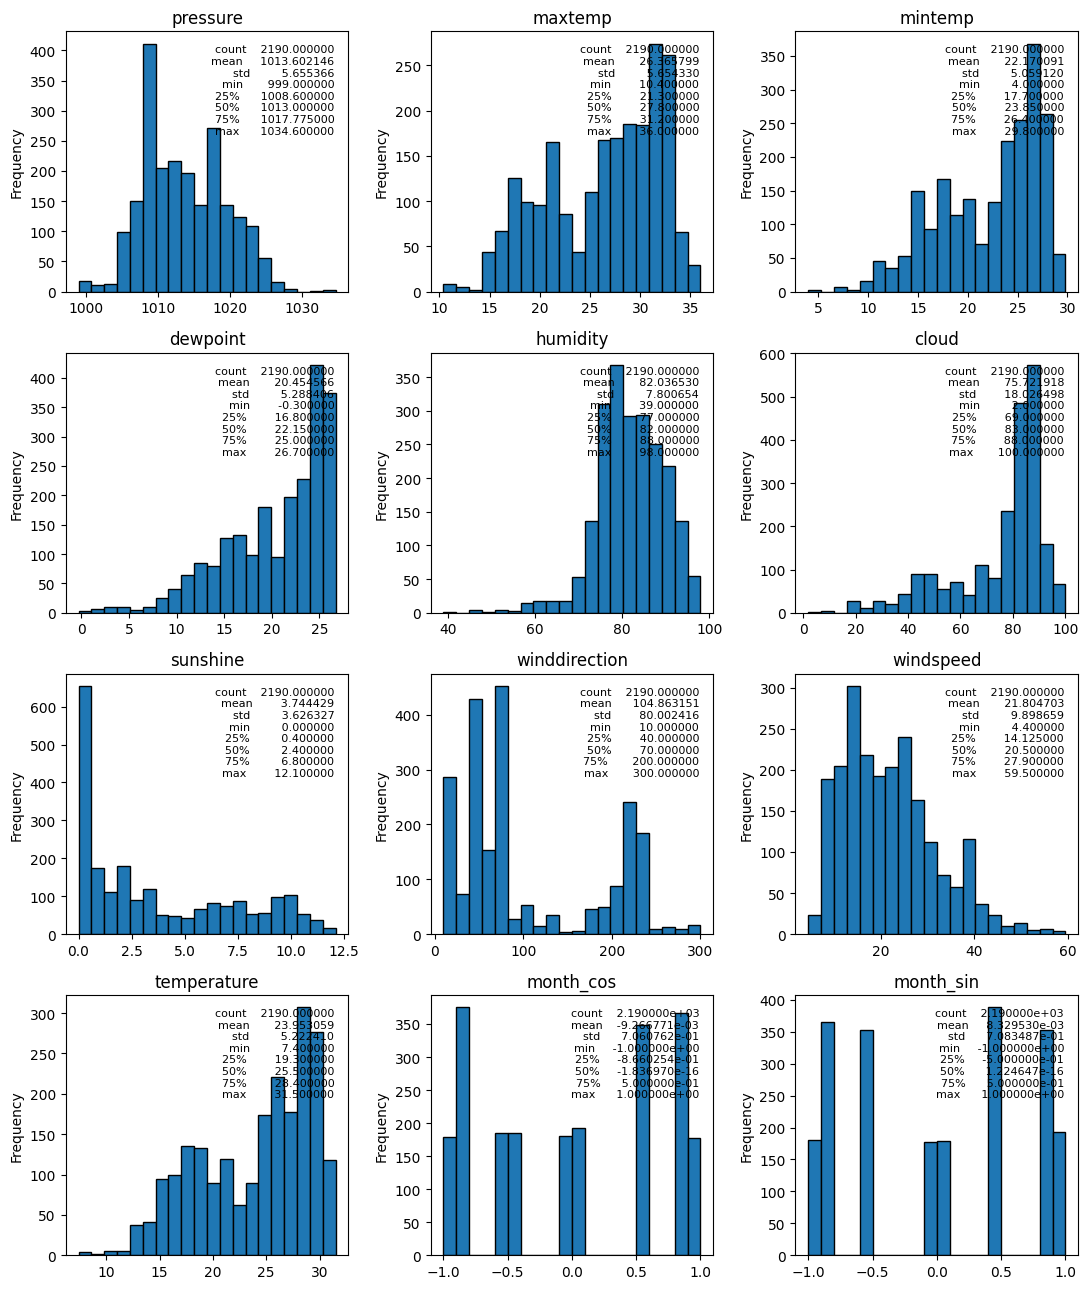

In [17]:
# check distribution & basic stats
distribution_stats_plot(X)

Data are mostly skewed (right_skewed), but there does not seem to be any errors, huge outliers or mostly constant feature. Moreovers, standard deviation remains low.

As long as we don't use a model that needs normalization or scaling, no need for any modification or synthetic data.

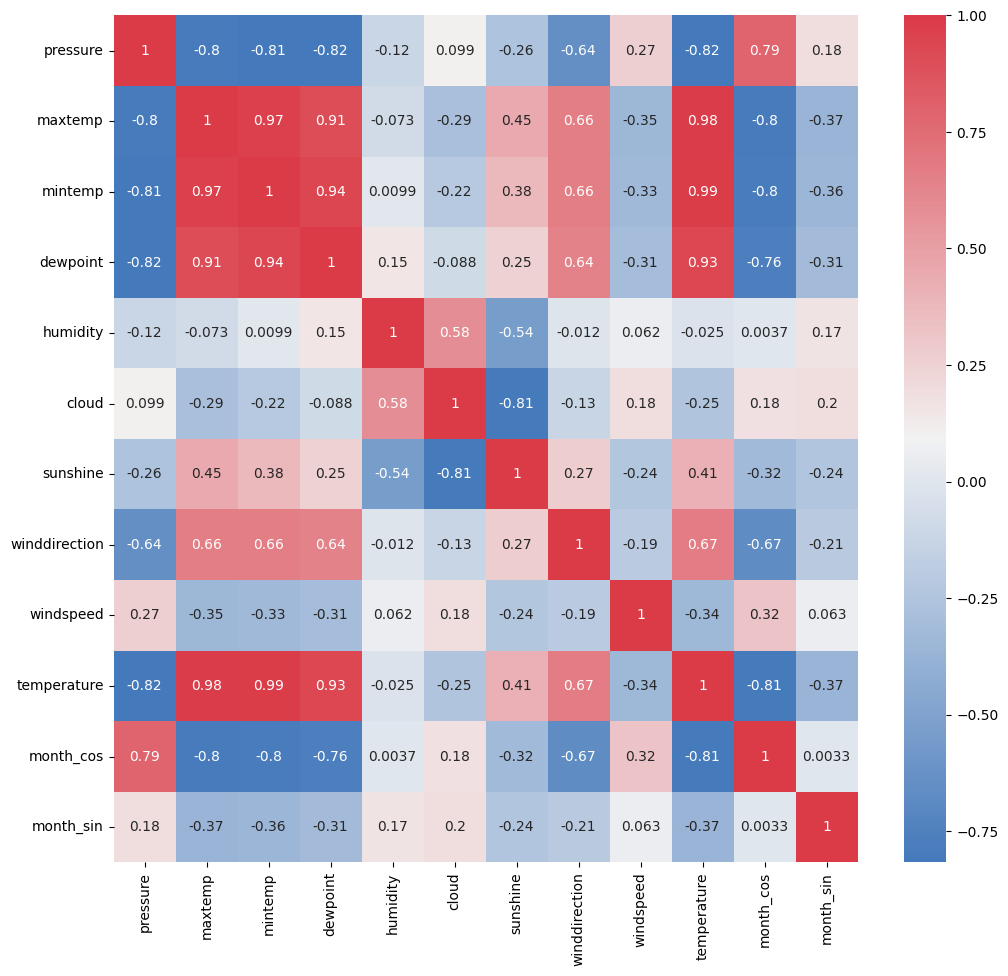

In [18]:
# check correlations
correlation_matrix(X)

High correlation between dewpoint, min,max, avg temperature and pressure. Quite obvious I guess since dewpoint is directly dependant on temperature and pressure.

We keep pressure and temperature only here.

In [19]:
X.drop(columns=["maxtemp", "mintemp", "dewpoint"], inplace=True)
X_test.drop(columns=["maxtemp", "mintemp", "dewpoint"], inplace=True)

There are not categorical features, so I guess this part is done.

# **<p style="text-align:center;">Modeling</p>**

Gradient boosting, random forest, logistic regression as models for binary classification with temporal elements.

Temporal splits for CV. Folds follow time, start with one year for training and validate on the second and keep expanding the training period per year.

In [ ]:
# make all 3 models
logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='liblinear'))
# actually no need to scale
forest = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
gradient_boost = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(random_state=42))
# time series split cut by years
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
model = logistic_regression
param_grid = {
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "logisticregression__class_weight": [None, "balanced"]
}

best_log = model_hyperparameters_evaluation_timesplitcv(model, param_grid, tscv,  X, y)

Fold 1: Best params = {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.912
Fold 2: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.915
Fold 3: Best params = {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.901
Fold 4: Best params = {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.885
Fold 5: Best params = {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.887


In [24]:
model = forest
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

best_forest = model_hyperparameters_evaluation_timesplitcv(model, param_grid, tscv,  X, y)

Fold 1: Best params = {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}, AUC = 0.895
Fold 2: Best params = {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}, AUC = 0.907
Fold 3: Best params = {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}, AUC = 0.892
Fold 4: Best params = {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split

In [77]:
model = gradient_boost
param_grid = {
    'histgradientboostingclassifier__learning_rate': [0.01, 0.1],
    'histgradientboostingclassifier__max_iter': [100, 200],
    'histgradientboostingclassifier__max_leaf_nodes': [31, 63, 127],
    'histgradientboostingclassifier__l2_regularization': [0.0, 0.1, 1.0],
}
best_gradboost = model_hyperparameters_evaluation_timesplitcv(model, param_grid, tscv,  X, y)

Fold 1: Best params = {'histgradientboostingclassifier__l2_regularization': 0.0, 'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_leaf_nodes': 31}, AUC = 0.895
Fold 2: Best params = {'histgradientboostingclassifier__l2_regularization': 0.0, 'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_leaf_nodes': 31}, AUC = 0.896
Fold 3: Best params = {'histgradientboostingclassifier__l2_regularization': 1.0, 'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_leaf_nodes': 31}, AUC = 0.901
Fold 4: Best params = {'histgradientboostingclassifier__l2_regularization': 0.0, 'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_leaf_nodes': 63}, AUC 

Best performing model is logistic regression.

In [ ]:
# Final model training
final_model = best_log
final_model.fit(X, y)  # Train on full 6-year data

# Predict on test
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

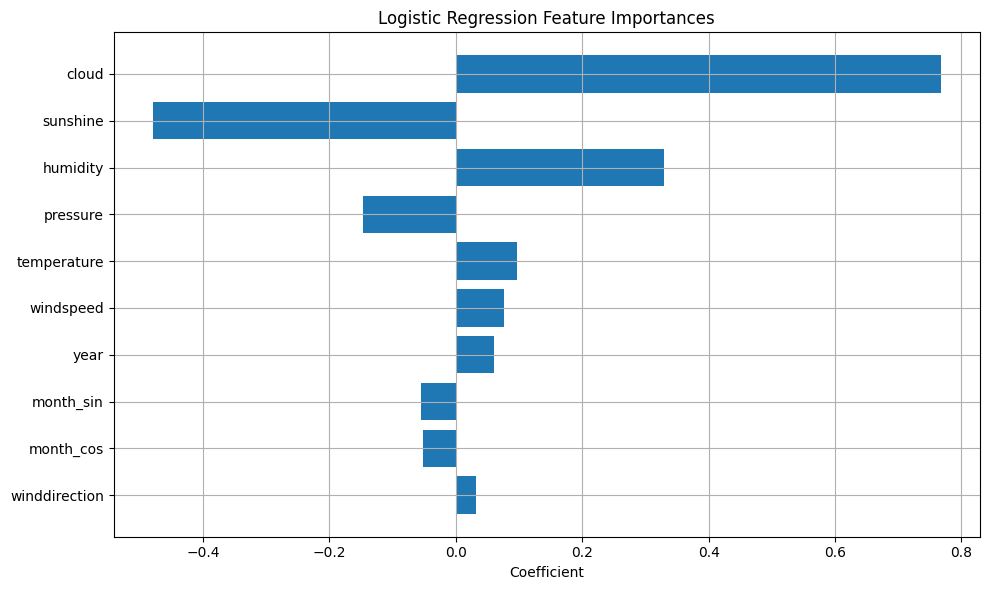

In [117]:
coefs = final_model["logisticregression"].coef_[0]
feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefs,
        'AbsCoefficient': np.abs(coefs)
}).sort_values(by='AbsCoefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][::-1], feature_importance['Coefficient'][::-1])
plt.xlabel('Coefficient')
plt.title('Logistic Regression Feature Importances')
plt.grid(True)
plt.tight_layout()
plt.show()

cloud, sunshine make up most of the importance and they are highly correlated (~80%), which means here a model with one feature being cloud might perform almost as well our models here.

In [ ]:
#fit on only cloud data
X2 = X["cloud"]
X2 = pd.DataFrame(X2)

model = logistic_regression
param_grid = {
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "logisticregression__class_weight": [None, "balanced"]
}

best_log = model_hyperparameters_evaluation_timesplitcv(model, param_grid, tscv,  X2, y)

Fold 1: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.885
Fold 2: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.911
Fold 3: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.871
Fold 4: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.863
Fold 5: Best params = {'logisticregression__C': 0.001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}, AUC = 0.879
